In [1]:
from pyrqa.time_series import TimeSeries, EmbeddedSeries
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric, MaximumMetric 
from pyrqa.analysis_type import Classic

from pyunicorn.timeseries import RecurrencePlot
from concurrent.futures import ThreadPoolExecutor

from surrogates import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

from dask import delayed, compute
from dask.diagnostics import ProgressBar
import pandas as pd
from rich.progress import Progress

from rqa_utils import *

In [4]:
# read in data

df = pd.read_csv('1ES_binned_lc.csv')
pred_df = pd.read_csv('1ES_pred_DHO_lc.csv')

lc, dho_lc = df['scaled lumin'].values, pred_df['lumin'].values

rp = RecurrencePlot(df['scaled lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=12, dim=5) #tau=9
pred_rp = RecurrencePlot(pred_df['lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=8, dim=6)

In [3]:
def get_rqa_measures(result):
    """
    Extract RQA measures from an RQAResult object and store them in a dictionary.
    
    Parameters:
        result: RQAResult object from pyrqa computation.
    
    Returns:
        dict: Dictionary of RQA measures.
    """
    result.min_diagonal_line_length = 2
    result.min_vertical_line_length = 2
    result.min_white_vertical_line_length = 2

    rqa_measures = {
        'RR': result.recurrence_rate,
        'DET': result.determinism,
        'ADL': result.average_diagonal_line,
        'LDL': result.longest_diagonal_line,
        'DIV': result.divergence,
        'ENTR': result.entropy_diagonal_lines,
        'LAM': result.laminarity,
        'TT': result.trapping_time,
        'LVL': result.longest_vertical_line,
        'VENTR': result.entropy_vertical_lines,
        'AVL': result.average_white_vertical_line,
        'LWVL': result.longest_white_vertical_line,
        'WVLENTR': result.entropy_white_vertical_lines,
        'DET/RR': result.ratio_determinism_recurrence_rate,
        'LAM/DET': result.ratio_laminarity_determinism
    }
    return rqa_measures

def embed_time_series(ts, tau, dim):
    """
    Embed a time series with given dimension and time delay.
    
    :param ts: 1D NumPy array or list containing the time series.
    :param dim: The embedding dimension.
    :param tau: The time delay (lag).
    :return: 2D NumPy array containing the embedded time series.
    """
    n = len(ts)
    if n < (dim - 1) * tau + 1:
        raise ValueError("Time series is too short for the given dimension and time delay")

    embedded_ts = np.empty((n - (dim - 1) * tau, dim))
    for i in range(dim):
        embedded_ts[:, i] = ts[i * tau: n - (dim - 1) * tau + i * tau]
    return embedded_ts

def convert_epsilon(time_series, epsilon, theiler=1):
    """ Finds recurrence rate corresponding to threshold value epsilon.
    param: time_series: pyrqa TimeSeries object
    param: epsilon: float (single threshold) or list/array (multiple thresholds)
    param: theiler: int: Theiler corrector
    """
    
    if isinstance(epsilon, (list, np.ndarray)): # list of epsilons supplied
        thresholds = epsilon  
    else: # if single epsilon is supplied
        thresholds = [epsilon]
    print("thresholds=", thresholds)
    # find corresponding RR for each value of epsilon
    recurrence_rates = []
    for epsilon in thresholds:
        settings = Settings(time_series,
                                analysis_type=Classic,
                                neighbourhood=FixedRadius(epsilon),
                                similarity_measure=MaximumMetric, #EuclideanMetric,
                                theiler_corrector=theiler)
            
        rqa = RQAComputation.create(settings).run()
        RR = rqa.recurrence_rate
        recurrence_rates.append(int(np.round(RR*100)))
       
    if isinstance(epsilon, (list, np.ndarray)): # list of epsilons supplied
        return recurrence_rates
    else: # if single epsilon is supplied
        return recurrence_rates[0]
    
    

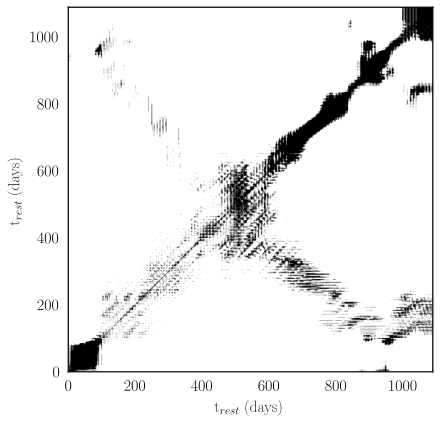

In [59]:
# plot the RP

rp = RecurrencePlot(df['scaled lumin'].values, metric='euclidean', silence_level=2, local_recurrence_rate=0.08, tau=9, dim=5)
tau, dim = 9, 5
ts = lc

# rp = RecurrencePlot(pred_df['lumin'].values, metric='euclidean', silence_level=2, local_recurrence_rate=0.08, tau=8, dim=6)
# tau, dim = 8, 6
# ts = dho_lc

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
# sc = plt.imshow(rp._distance_matrix, origin='lower', cmap="Purples_r")
sc = plt.imshow(rp.recurrence_matrix(), origin='lower', cmap="Greys")
plt.xlabel(r't$_{rest}$ (days)')
plt.ylabel(r't$_{rest}$ (days)')
plt.tick_params(which="both", axis="both", top=False, left=False, right=False, bottom=False)

# divider = make_axes_locatable(plt.gca())
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cb = plt.colorbar(sc, cax=cax, label=r"Threshold Distance ($\epsilon$)") #Recurrence Rate (\%)")
# thresholds = cb.ax.get_yticks()
# time_series = TimeSeries(ts, embedding_dimension=dim, time_delay=tau)
# recurrence_rates = convert_epsilon(time_series, thresholds, theiler=tau*dim) #9*5)
# # cb.ax.set_yticks(thresholds)
# # cb.ax.set_yticklabels(recurrence_rates)
# cb.ax.tick_params(which="both", right=False, left=False)

# plt.savefig('../plots/1ES_dist_matrix.pdf', bbox_inches='tight')
# plt.savefig('../plots/1ES_pred_DHO_dist_matrix.pdf', bbox_inches='tight')
plt.savefig('../plots/1ES_rp_matrix_euclidean.pdf', bbox_inches='tight')
# plt.savefig('../plots/1ES_pred_DHO_rp_matrix_euclidean.pdf', bbox_inches='tight')
plt.show()



In [44]:
recurrence_rates = []
for epsilon in cb.ax.get_yticks():
        settings = Settings(time_series,
                                analysis_type=Classic,
                                neighbourhood=FixedRadius(epsilon),
                                similarity_measure=MaximumMetric, #EuclideanMetric,
                                theiler_corrector=tau*dim)
            
        rqa = RQAComputation.create(settings).run()
        RR = rqa.recurrence_rate
        print(int(np.round(RR*100)))
        # recurrence_rates.append(int(np.round(RR*100)))

0
16
35
49
65
86
98
100
100


In [83]:
from pyrqa.neighbourhood import Unthresholded
import pandas as pd

# Initialize dictionaries to store RQA metrics for each dataset
rqa_metrics_original = {}
rqa_metrics_dho = {}

# Loop over data (lc is original and pred_lc is DHO)
rqa_results = []
for i, (ts, tau, dim) in enumerate(zip([lc, pred_lc], [12, 5], [5, 6])): # tau=9, dim=8
    
    epsilon = find_epsilon(ts, 0.05, tau=tau, dim=dim)
    print("epsilon=", epsilon)
    
    time_series = TimeSeries(ts, embedding_dimension=dim, time_delay=tau)
    settings = Settings(time_series,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(epsilon),
                        similarity_measure=MaximumMetric,
                        theiler_corrector=tau*dim)
                        
    computation = RQAComputation.create(settings)
    result = computation.run()
    rqa = get_rqa_measures(result)
    rqa_results.append(result)
    
    # Assign the RQA measures to the respective dictionary
    if i == 0:  # original data (lc)
        rqa_metrics_original = rqa
    else:  # DHO data (pred_lc)
        rqa_metrics_dho = rqa

# Creating the DataFrame
# Extract RQA metric names
rqa_metric_names = list(rqa_metrics_original.keys())

# Prepare data for the DataFrame
data = {
    'RQA': rqa_metric_names,
    'original': [rqa_metrics_original[metric] for metric in rqa_metric_names],
    'DHO': [rqa_metrics_dho[metric] for metric in rqa_metric_names]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


epsilon= 0.40234375
epsilon= 0.35546875
        RQA    original         DHO
0        RR    0.105929    0.101850
1       DET    0.878013    0.932703
2       ADL    8.193696   12.184448
3       LDL   90.000000  113.000000
4       DIV    0.011111    0.008850
5      ENTR    2.363748    2.469829
6       LAM    0.953670    0.968711
7        TT   15.083828   21.095061
8       LVL  243.000000  177.000000
9     VENTR    2.947076    3.053778
10      AVL   98.233121  130.405588
11     LWVL  970.000000  975.000000
12  WVLENTR    4.050102    4.393877
13   DET/RR    8.288695    9.157577
14  LAM/DET    1.086169    1.038607


Comparing RQA with no Theiler correction applied

In [179]:
from pyrqa.neighbourhood import Unthresholded
import pandas as pd

# Initialize dictionaries to store RQA metrics for each dataset
rqa_metrics_original = {}
rqa_metrics_dho = {}

# Loop over data (lc is original and pred_lc is DHO)
rqa_results2 = []
for i, (ts, tau, dim) in enumerate(zip([lc, pred_lc], [12, 5], [5, 6])): # tau=9, dim=8
    
    epsilon = find_epsilon(ts, 0.05) #, tau=tau, dim=dim)
    print("epsilon=", epsilon)
    
    time_series = TimeSeries(ts, embedding_dimension=dim, time_delay=tau)
    settings = Settings(time_series,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(epsilon),
                        similarity_measure=MaximumMetric) #,
                        #theiler_corrector=tau*dim)
                        
    computation = RQAComputation.create(settings)
    result = computation.run()
    rqa = get_rqa_measures(result)
    rqa_results2.append(result)
    
    # Assign the RQA measures to the respective dictionary
    if i == 0:  # original data (lc)
        rqa_metrics_original = rqa
    else:  # DHO data (pred_lc)
        rqa_metrics_dho = rqa

# Creating the DataFrame
# Extract RQA metric names
rqa_metric_names2 = list(rqa_metrics_original.keys())

# Prepare data for the DataFrame
data2 = {
    'RQA': rqa_metric_names2,
    'original': [rqa_metrics_original[metric] for metric in rqa_metric_names2],
    'DHO': [rqa_metrics_dho[metric] for metric in rqa_metric_names2]
}

# Create the DataFrame
df2 = pd.DataFrame(data2)

# Print the DataFrame
print(df2)


epsilon= 0.0517578125
epsilon= 0.051513671875
        RQA     original          DHO
0        RR     0.003602     0.005321
1       DET     0.813833     0.908033
2       ADL     4.022364     3.926948
3       LDL    22.000000    93.000000
4       DIV     0.045455     0.010753
5      ENTR     1.864792     1.484318
6       LAM     0.772902     0.876925
7        TT     4.427198     5.252563
8       LVL    14.000000    36.000000
9     VENTR     1.999002     1.988183
10      AVL   460.801838   439.992308
11     LWVL  1074.000000  1098.000000
12  WVLENTR     6.478908     6.159150
13   DET/RR   225.956014   170.643100
14  LAM/DET     0.949705     0.965742


In [186]:
def get_close_returns(rqa, lag=None, type='diagonal', max_lag=-1):
    """ Returns the number of diagonal lines at length=lag. """
    if type == 'diagonal':
        close_returns = rqa.diagonal_frequency_distribution
    elif type == 'vertical':
        close_returns = rqa.vertical_frequency_distribution

    line_lengths = range(1,len(close_returns))  # Line lengths (time lags)
    frequencies = close_returns[1:]  # Frequencies of each line length
    
    if lag is not None:
        freq = frequencies[lag-1]
        print(f"Close returns at t_lag = {lag} is {freq}")
        return freq
    else:
        if max_lag == -1: # return whole distribution
            return line_lengths, frequencies
        elif max_lag > 0:
            return line_lengths[:max_lag], frequencies[:max_lag]
        else: 
            print("Error! Max_lag must be greater than 0.")

get_close_returns(rqa_results[0], lag=10, type='vertical', max_lag=100), get_close_returns(rqa_results[0], lag=10)

Close returns at t_lag = 10 is 527
Close returns at t_lag = 10 is 722


(527, 722)

Text(0, 0.5, 'Frequency')

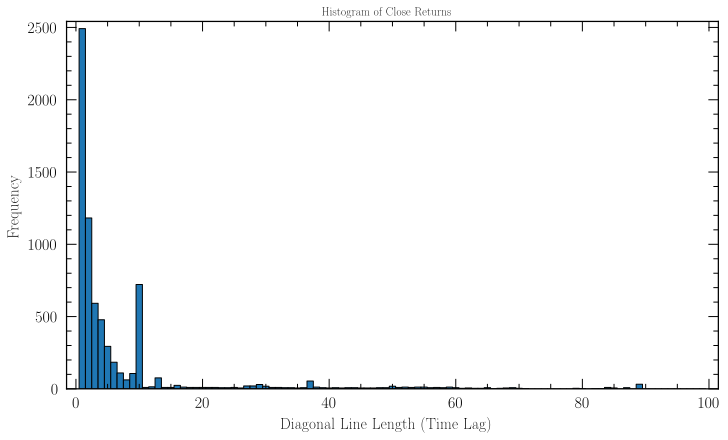

In [132]:
# df.to_csv('../data/1ES_compare_DHO_RQA_supremum_RR_5%.csv', index=None)

close_returns = rqa_results[0].diagonal_frequency_distribution[:100]

# Prepare the data
line_lengths = range(1, len(close_returns))  # Line lengths (time lags)
frequencies = close_returns[1:]  # Frequencies of each line length

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(line_lengths, frequencies, width=1.0, edgecolor='black')
plt.title('Histogram of Close Returns')
plt.xlabel('Diagonal Line Length (Time Lag)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

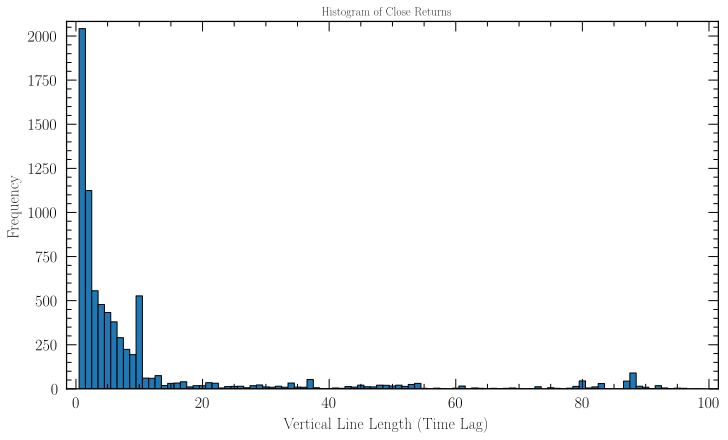

In [131]:
# close_returns = rqa_results[0].diagonal_frequency_distribution[:100]
cr = rqa_results[0].vertical_frequency_distribution[:100] 

# Prepare the data
line_lengths = range(1, len(cr))  # Line lengths (time lags)
frequencies = cr[1:]  # Frequencies of each line length

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(line_lengths, frequencies, width=1.0, edgecolor='black')
plt.title('Histogram of Close Returns')
plt.xlabel('Vertical Line Length (Time Lag)')
plt.ylabel('Frequency')

DHO predicted close returns

Text(0, 0.5, 'Frequency')

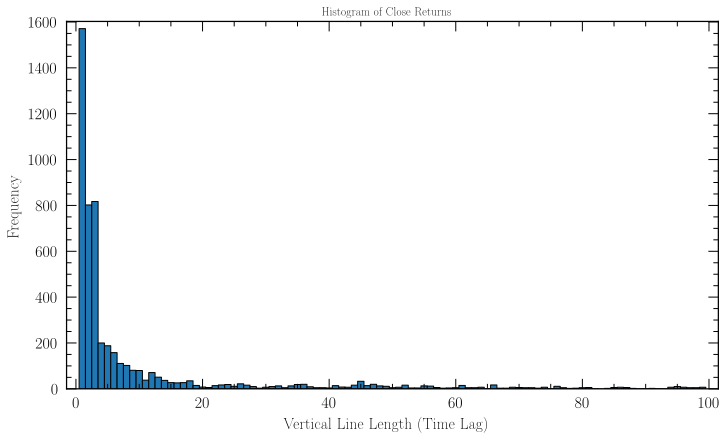

In [133]:
# close_returns = rqa_results[0].diagonal_frequency_distribution[:100]
cr = rqa_results[1].vertical_frequency_distribution[:100] 

# Prepare the data
line_lengths = range(1, len(cr))  # Line lengths (time lags)
frequencies = cr[1:]  # Frequencies of each line length

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(line_lengths, frequencies, width=1.0, edgecolor='black')
plt.title('Histogram of Close Returns')
plt.xlabel('Vertical Line Length (Time Lag)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

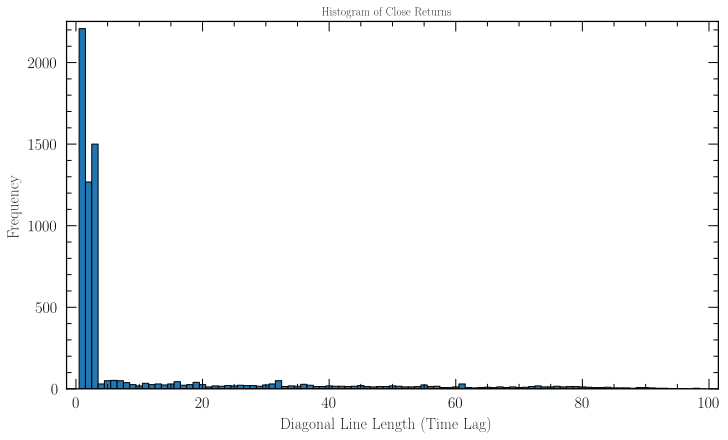

In [134]:
close_returns = rqa_results[1].diagonal_frequency_distribution[:100]

# Prepare the data
line_lengths = range(1, len(close_returns))  # Line lengths (time lags)
frequencies = close_returns[1:]  # Frequencies of each line length

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(line_lengths, frequencies, width=1.0, edgecolor='black')
plt.title('Histogram of Close Returns')
plt.xlabel('Diagonal Line Length (Time Lag)')
plt.ylabel('Frequency')

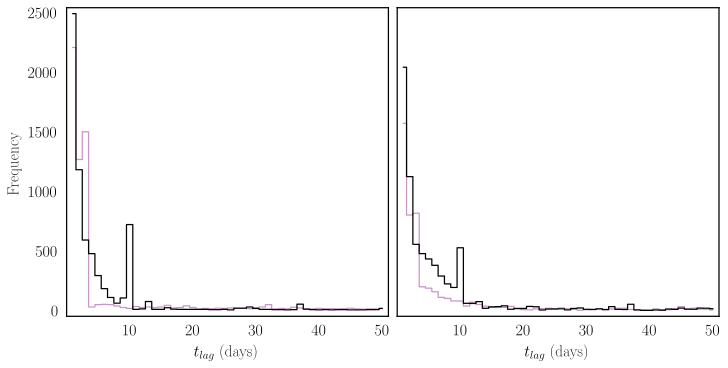

In [194]:

# Creating a 2x2 subplot figure.
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey="row") #, layout='constrained',

# Plot configurations
types = ['diagonal', 'vertical']
# y_labels = ['Frequency of Diagonal Lines', 'Frequency of Vertical Lines']
y_labels = ['Frequency', 'Frequency']
colors = ['k', "#c994c7"]
labels = ['Original', 'DHO']
zorder = [2, 1]

for i, rqa_result in enumerate(rqa_results):
    color = colors[i]
    # axs[i].set_title(f'{"Diagonal" if i == 0 else "Vertical"} Close Returns')
    
    # axs[i].set_title(f'{"1ES 1927+654" if i == 0 else "Best-Fit DHO Predicted"} Close Returns')
    for j, lag_type in enumerate(types):

        line_lengths, frequencies = get_close_returns(rqa_result, type=lag_type, max_lag=50)
        axs[j].step(line_lengths, frequencies, linewidth=1.25, label=labels[i], color=color, zorder=zorder[i], where='mid') #, edgecolor='black')
        # axs[j].plot(line_lengths, frequencies, linewidth=1.25, label=labels[i], color=color, zorder=zorder[i], marker=m) #, edgecolor='black')
        axs[j].set_xlabel(r'$t_{lag}$ (days)')
        axs[j].set_ylabel(y_labels[j])
        # axs[j].set_yscale('log')
    # axs[i].margins(x=0.05, y=0.045)
    axs[i].label_outer()
    axs[i].tick_params(which="both", axis="both", top=False, left=False, bottom=False, right=False)
# for ax in axs.flatten(): ax.legend()
# plt.subplots_adjust(wspace=0)
plt.savefig('../plots/1ES_compare_DHO_close_returns.pdf', bbox_inches='tight')
plt.show()


Comparing close returns with no Theiler correction applied

/var/folders/1t/cw_9qncx42l90j4kknls85g80000gn/T/ipykernel_13203/1946440403.py:28: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0)


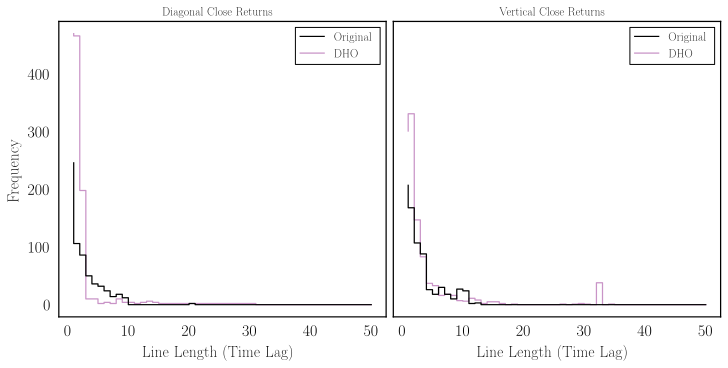

In [180]:

# Creating a 2x2 subplot figure.
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey="row") #, layout='constrained',

# Plot configurations
types = ['diagonal', 'vertical']
# y_labels = ['Frequency of Diagonal Lines', 'Frequency of Vertical Lines']
y_labels = ['Frequency', 'Frequency']
colors = ['k', "#c994c7"]
labels = ['Original', 'DHO']
zorder = [2, 1]

for i, rqa_result in enumerate(rqa_results2):
    color = colors[i]
    axs[i].set_title(f'{"Diagonal" if i == 0 else "Vertical"} Close Returns')
    
    # axs[i].set_title(f'{"1ES 1927+654" if i == 0 else "Best-Fit DHO Predicted"} Close Returns')
    for j, lag_type in enumerate(types):

        line_lengths, frequencies = get_close_returns(rqa_result, type=lag_type, max_lag=50)
        axs[j].step(line_lengths, frequencies, linewidth=1.25, label=labels[i], color=color, zorder=zorder[i]) #, edgecolor='black')
        axs[j].set_xlabel('Line Length (Time Lag)')
        axs[j].set_ylabel(y_labels[j])
        # axs[j].set_yscale('log')
    axs[i].margins(x=0.05, y=0.045)
    axs[i].label_outer()
    axs[i].tick_params(which="both", axis="both", top=False, left=False, bottom=False, right=False)
for ax in axs.flatten(): ax.legend()
plt.subplots_adjust(wspace=0)
plt.savefig('../plots/1ES_compare_DHO_close_returns_noTheiler.pdf', bbox_inches='tight')
plt.show()


In [78]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from surrogates import *

def compute_measure(surrogate, rqa_measure_func, tau, dim, lag_of_interest):
    return rqa_measure_func(surrogate, tau, dim, lag_of_interest)

def test_significance(original_series, tau, dim, surrogates, rqa_measure_func, lag_of_interest):
    # Compute the RQA measure for the original series
    original_measure = rqa_measure_func(original_series, tau, dim, lag_of_interest)

    # Prepare a partial function that already includes the static arguments
    partial_compute_measure = partial(compute_measure, rqa_measure_func=rqa_measure_func, tau=tau, dim=dim, lag_of_interest=lag_of_interest)

    # Compute measures in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        # Since the partial function already includes the static arguments, only surrogates need to be passed
        surrogate_measures = list(executor.map(partial_compute_measure, surrogates))

    # Calculate the empirical p-value (one-tailed test)
    extreme_high_count = np.sum(np.array(surrogate_measures) >= original_measure)
    p_value = extreme_high_count / len(surrogates)

    return p_value, surrogate_measures

def rqa_measure_func(ts, tau, dim, lag):
    # This should return the RQA measure of interest at the specified lag
    epsilon = find_epsilon(ts, 0.05, tau=tau, dim=dim, theiler=tau*dim)
    
    time_series = TimeSeries(ts, embedding_dimension=dim, time_delay=tau)
    settings = Settings(time_series,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(epsilon),
                        similarity_measure=MaximumMetric,
                        theiler_corrector=tau*dim)
                        
    rqa = RQAComputation.create(settings).run()
    close_returns = rqa.diagonal_frequency_distribution[:100]

    # Prepare the data
    line_lengths = range(1, len(close_returns))  # Line lengths (time lags)
    frequencies = close_returns[1:]  # Frequencies of each line length

    return frequencies[lag-1]

In [94]:
# Create surrogates
surrogates = {}
for sur_type in ['phase_randomized', 'white_noise', 'correlated_noise', 'IAAFT', 'AAFT', 'time_reversed']:
    surrogates[sur_type] = generate_surrogates(sur_type, lc, 100)

np.savez_compressed('../data/1ES_surrogates.npz', **surrogates)

In [96]:
# perform significance testing
print("phase_randomized surrogates P-value: 0.0")

for sur_type in ['white_noise', 'correlated_noise', 'IAAFT', 'AAFT', 'time_reversed']:
    p_value, sur_freqs = test_significance(lc, tau, dim, surrogates[sur_type], rqa_measure_func, lag_of_interest=10)
    print(f"{sur_type} surrogates P-value: {p_value}")


phase_randomized surrogates P-value: 0.0
white_noise surrogates P-value: 0.0
correlated_noise surrogates P-value: 0.0
IAAFT surrogates P-value: 0.04
AAFT surrogates P-value: 0.09
time_reversed surrogates P-value: 1.0


(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([721.5, 721.6, 721.7, 721.8, 721.9, 722. , 722.1, 722.2, 722.3,
        722.4, 722.5]),
 <BarContainer object of 10 artists>)

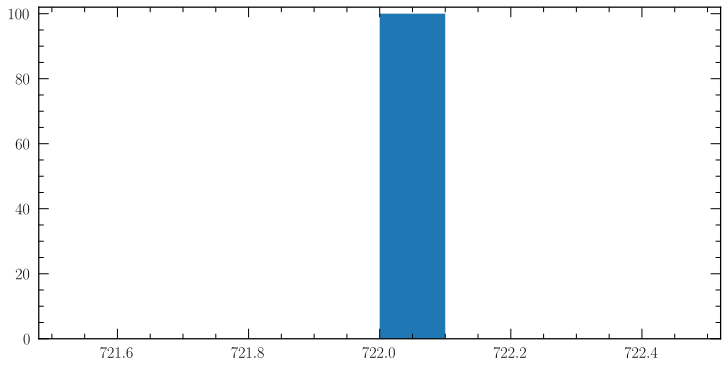

In [97]:

plt.hist(sur_freqs)

In [93]:
# plt.hist(sur_freqs)
tau, dim = 12,5
print(rqa_measure_func(ts, tau, dim, 10))
time_series = TimeSeries(ts, embedding_dimension=dim, time_delay=tau)
settings = Settings(time_series,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(epsilon),
                    similarity_measure=MaximumMetric,
                    theiler_corrector=tau*dim)
                    
computation = RQAComputation.create(settings)
result = computation.run()

get_close_returns(result, 10)

454
Close returns at t_lag = 10 is 288


In [ ]:
# weight the windowed RQA values 

import numpy as np

# Dummy data: DET values and duration in each state
det_values = np.array([0.5, 0.6, 0.55, 0.65, 0.6, 0.7])  # DET values for each sub-RP
duration_hard = np.array([100, 80, 120, 90, 110, 70])  # Duration in hard state for each sub-RP
duration_soft = np.array([200, 220, 180, 210, 190, 230])  # Duration in soft state for each sub-RP

# Calculate total duration
total_duration = duration_hard + duration_soft

# Calculate weights for each state
weight_hard = duration_hard / total_duration
weight_soft = duration_soft / total_duration

# Calculate weighted average DET for each state
weighted_avg_det_hard = np.sum(det_values * weight_hard)
weighted_avg_det_soft = np.sum(det_values * weight_soft)

print(f'Weighted Average DET for Hard State: {weighted_avg_det_hard}')
print(f'Weighted Average DET for Soft State: {weighted_avg_det_soft}')


#### STILL NEED TO WORK ON THIS

<Figure size 1000x500 with 0 Axes>

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


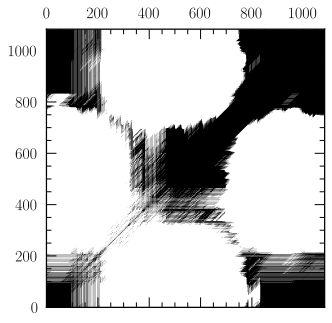

In [10]:
from pyrqa.variants.rqa.radius.column_no_overlap_materialisation_bit_no_recycling import ColumnNoOverlapMaterialisationBitNoRecycling
from pyrqa.variants.rqa.radius.column_no_overlap_materialisation_bit_recycling import ColumnNoOverlapMaterialisationBitRecycling
from pyrqa.variants.rqa.radius.column_no_overlap_materialisation_byte_no_recycling import ColumnNoOverlapMaterialisationByteNoRecycling
from pyrqa.variants.rqa.radius.column_no_overlap_materialisation_byte_recycling import ColumnNoOverlapMaterialisationByteRecycling
from pyrqa.variants.rqa.radius.column_no_overlap_no_materialisation import ColumnNoOverlapNoMaterialisation
from pyrqa.variants.rqa.radius.column_overlap_materialisation_bit_no_recycling import ColumnOverlapMaterialisationBitNoRecycling
from pyrqa.variants.rqa.radius.column_overlap_materialisation_bit_recycling import ColumnOverlapMaterialisationBitRecycling
from pyrqa.variants.rqa.radius.column_overlap_materialisation_byte_no_recycling import ColumnOverlapMaterialisationByteNoRecycling
from pyrqa.variants.rqa.radius.column_overlap_materialisation_byte_recycling import ColumnOverlapMaterialisationByteRecycling
from pyrqa.variants.rqa.radius.column_overlap_no_materialisation import ColumnOverlapNoMaterialisation
from pyrqa.selector import EpsilonGreedySelector
from pyrqa.metric import MaximumMetric

df = pd.read_csv('1ES_binned_lc.csv')
pred_df = pd.read_csv('1ES_pred_DHO_lc.csv')
lc, pred_lc = df['scaled lumin'].values, pred_df['lumin'].values
time_series = TimeSeries(lc,embedding_dimension=9,time_delay=5)
settings = Settings(time_series,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(1),
                    similarity_measure=MaximumMetric,
                    theiler_corrector=9*5)
rqa = RQAComputation.create(settings,
                                    selector=EpsilonGreedySelector(explore=30)).run()
from pyrqa.computation import RPComputation
rp = RPComputation.create(settings).run()
rp_matrix = rp.recurrence_matrix

plt.figure()
plt.matshow(rp_matrix, origin='lower', cmap='Greys', interpolation='none')
plt.show()

In [9]:
def find_epsilon(time_series_data, target_recurrence_rate, tau=1, dim=1, theiler=1, initial_epsilon=1.0, tolerance=0.0001, max_iterations=100):
    """
    Find the epsilon value that corresponds to a given recurrence rate.
    
    Parameters:
        time_series_data (np.array): The time series data.
        target_recurrence_rate (float): The target recurrence rate.
        initial_epsilon (float): Initial guess for epsilon.
        tolerance (float): Tolerance for the difference between current and target recurrence rates.
        max_iterations (int): Maximum number of iterations to perform.
        
    Returns:
        float: The epsilon value corresponding to the target recurrence rate.
    """
    lower_epsilon = 0
    upper_epsilon = initial_epsilon
    current_epsilon = initial_epsilon
    time_series = TimeSeries(time_series_data, time_delay=tau, embedding_dimension=dim)
    
    for _ in range(max_iterations):
        settings = Settings(time_series,
                            analysis_type=Classic,
                            neighbourhood=FixedRadius(current_epsilon),
                            similarity_measure=EuclideanMetric,
                            theiler_corrector=tau*dim)
        
        rqa_computation = RQAComputation.create(settings)
        rqa_result = rqa_computation.run()
        current_recurrence_rate = rqa_result.recurrence_rate
        
        if abs(current_recurrence_rate - target_recurrence_rate) < tolerance:
            return current_epsilon  # Found the epsilon corresponding to the target recurrence rate

        # Update the search bounds and current epsilon based on the comparison
        if current_recurrence_rate > target_recurrence_rate:
            upper_epsilon = current_epsilon
            current_epsilon = (lower_epsilon + upper_epsilon) / 2
        else:
            lower_epsilon = current_epsilon
            current_epsilon = (lower_epsilon + upper_epsilon) / 2
    
    return current_epsilon  # Return the best approximation of epsilon after max_iterations

In [3]:
# Function to calculate RQA measures for a given window
calculate_rqa_measures(window, epsilon, tau, dim, i)

# Function to compute measures in parallel for each window
compute_measures_in_parallel(ts, tau, dim, window_size, step_size, epsilon)

rqa_stats = []
# for i, (ts, tau, dim, color) in enumerate(zip([pred_lc, lc], [8, 9], [6, 5], ["#c994c7", 'k'])):
    
# embed full time series
ts, dim, tau = lc, 9, 5
embedded_ts = embed_time_series(ts, dim, tau)

# check if find_epsilon differs 
window_size, step_size = 250, 1
epsilon = find_epsilon(ts, 0.05, tau=tau, dim=dim) # use RR=5% across full RP
rqa_df = compute_measures_in_parallel(embedded_ts, tau, dim, window_size, step_size, epsilon)

# add column 'TIME' for center time of each window
rqa_df['time'] = window_size + rqa_df['window'].values * step_size
rqa_stats.append(rqa_df)

In [101]:
import time
from rich.progress import Progress
import dask.dataframe as dd
from dask.delayed import delayed


# Function to calculate RQA measures for a given window
def calculate_rqa_measures(ts, tau=1, dim=1, epsilon=0.05, metric='euclidean', window=-1, step_size=None, opencl=None):
    
    if window != -1: # ts is a windowed segment of embedded time series
        time_series = EmbeddedSeries(ts) 

    else: # construct regular time series object, ts is the full time series
        time_series = TimeSeries(ts, time_delay=tau, embedding_dimension=dim)
    
    distance_metrics = {'euclidean': EuclideanMetric, 'supremum': MaximumMetric}
    
    settings = Settings(time_series,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(epsilon),
                        similarity_measure=distance_metrics[metric.lower()],
                        theiler_corrector=tau*dim)
    
    # Perform RQA computation
    result = RQAComputation.create(settings, opencl=opencl).run()
    
    rqa = get_rqa_measures(result)
    if window != -1:
        rqa['window'] = window  # Add window index to the results
    if step_size: rqa['time'] = window_size + window * step_size # center time of the window

    return rqa

from concurrent.futures import ThreadPoolExecutor, as_completed

# def compute_measures_in_parallel(ts, tau, dim, epsilon, metric, window_size, step_size):
#     # Compute RQA measures for a single surrogate for all its windows
#     # This function will return a DataFrame with results for all windows of one surrogate

#     # calculate windows from embedded time series if sliding windowing params supplied
#     results = []
#     if window_size and step_size: 
#         # embed full time series and calculate windows
#         embedded_ts = embed_time_series(ts, tau, dim)
#         for i in range(0, len(embedded_ts) - window_size + 1, step_size):
#             window = embedded_ts[i:i + window_size]
#             # Calculate RQA measures for each window
#             rqa_result = calculate_rqa_measures(window, tau, dim, epsilon, metric, i, step_size)
#             results.append(rqa_result)
#     else:
#         # Calculate RQA measures for the full time series (no windowing)
#         rqa_result = calculate_rqa_measures(ts, tau, dim, epsilon, metric)
#         results.append(rqa_result)

#     # Convert the list of dictionaries to a DataFrame
#     return pd.DataFrame(results)

def compute_measures_in_parallel2(ts, tau, dim, epsilon, metric, window_size, step_size, opencl, **kwargs):
    results = []
    
    # Function to execute for each window
    def compute_for_window(i, window, opencl):
        rqa_result = calculate_rqa_measures(window, tau, dim, epsilon, metric, i, step_size, opencl)
        return rqa_result
    
    if window_size and step_size:
        # embed full time series and calculate windows
        embedded_ts = embed_time_series(ts, tau, dim)
        with ThreadPoolExecutor(max_workers=4) as executor:
            # Prepare the list of tasks
            tasks = {executor.submit(compute_for_window, i, embedded_ts[i:i + window_size], opencl): i for i in range(0, len(embedded_ts) - window_size + 1, step_size)}
            
            # Execute the tasks concurrently
            for future in as_completed(tasks):
                rqa_results = future.result()
                if kwargs:
                    rqa_results['surrogate_id'] = kwargs['surrogate_id']
                    rqa_results['surrogate_type'] = kwargs['surrogate_type']
                results.append(rqa_results)
    else:
        # Calculate RQA measures for the full time series (no windowing)
        rqa_results = calculate_rqa_measures(ts, tau, dim, epsilon, metric)
        if kwargs:
            rqa_results['surrogate_id'] = kwargs['surrogate_id']
            rqa_results['surrogate_type'] = kwargs['surrogate_type']
        results.append(rqa_results)
    
    return pd.DataFrame(results)

import multiprocessing
cpu_count = multiprocessing.cpu_count()
# num_workers = min(32, (multiprocessing.cpu_count() or 1) * 4)
    
# def get_surrogate_rqa(ts, tau, dim, N, surrogate_types, recurrence_rates, metric, window_size=None, step_size=None):
    
#     # setup OpenCL runtime
#     from pyrqa.opencl import OpenCL
#     opencl = OpenCL(platform_id=0, device_ids=(0,))
    
#     if not isinstance(surrogate_types, (list, np.ndarray)):
#         surrogate_types = [surrogate_types]
#     if not isinstance(recurrence_rates, (list, np.ndarray)):
#         recurrence_rates = [recurrence_rates]

#     # all_results = []
#     # with ThreadPoolExecutor(max_workers=4) as executor:
#     #     futures = []
#     #     # Assign a unique surrogate_id to each surrogate
#     #     for surrogate_idx, surrogate_type in enumerate(tqdm(surrogate_types, desc="Total Progress")):
#     #         print(f"Generating {surrogate_type} surrogates...")
#     #         surrogate_type_start = time.time()
#     #         surrogates = generate_surrogates(surrogate_type, ts, N)
#     #         for surrogate_id, surrogate in enumerate(tqdm(surrogates, desc=f"{surrogate_type.replace('_', ' ').title()} Surrogates")):
#     #             surrogate_start = time.time()
#     #             for RR in recurrence_rates:
#     #                 epsilon = find_epsilon(surrogate, RR, tau, dim)
#     #                 # Submit task for parallel execution
#     #                 future = executor.submit(compute_measures_in_parallel2, surrogate, tau, dim, epsilon, metric, window_size, step_size)
#     #                 futures.append((future, surrogate_id, surrogate_type, RR))
#     #             print(f"     surrogate {surrogate_id + 1} took {time.time() - surrogate_start} seconds")
#     #         print(f"...took {time.time() - surrogate_type_start} seconds")
                    
#     #     # Collect results as they complete
#     #     for future, surrogate_id, surrogate_type, RR in tqdm(futures, desc="Completed Surrogates"):
#     #         rqa_df = future.result()
#     #         rqa_df['surrogate_id'] = surrogate_id
#     #         rqa_df['surrogate_type'] = surrogate_type
#     #         rqa_df['RR'] = RR
#     #         all_results.append(rqa_df)
    
#     all_results = []
#     with ThreadPoolExecutor(max_workers=4) as executor, Progress() as progress:
        
#         surrogate_task = progress.add_task("[red]Generating surrogates...", total=len(surrogate_types))

#         for surrogate_idx, surrogate_type in enumerate(surrogate_types):
#             progress.update(surrogate_task, advance=1, description=f"[red]Generating {surrogate_type} surrogates...")
#             surrogate_type_start = time.time()
#             surrogates = generate_surrogates(surrogate_type, ts, N)
#             surrogate_progress_task = progress.add_task(f"[green]{surrogate_type.replace('_', ' ').title()} Surrogates...", total=len(surrogates))

#             futures = []
#             for surrogate_id, surrogate in enumerate(surrogates):
#                 progress.update(surrogate_progress_task, advance=1)
#                 surrogate_start = time.time()
#                 for RR in recurrence_rates:
#                     epsilon = find_epsilon(surrogate, RR, tau, dim)
#                     future = executor.submit(compute_measures_in_parallel, surrogate, tau, dim, epsilon, metric, window_size, step_size)
#                     futures.append((future, surrogate_id, surrogate_type, RR))

#             results_task = progress.add_task("[cyan]Collecting results...", total=len(futures))
#             for future, surrogate_id, surrogate_type, RR in futures:
#                 rqa_df = future.result()
#                 rqa_df['surrogate_id'] = surrogate_id
#                 rqa_df['surrogate_type'] = surrogate_type
#                 rqa_df['RR'] = RR
#                 all_results.append(rqa_df)
#                 progress.update(results_task, advance=1)

#     # Combine all DataFrames
#     final_df = pd.concat(all_results, ignore_index=True)

#     # Set the index
#     if len(surrogate_types) > 1 and len(recurrence_rates) > 1:
#         final_df.set_index(['surrogate_id', 'surrogate_type', 'RR'], inplace=True)
#     elif len(recurrence_rates) > 1:
#         final_df.set_index(['surrogate_id', 'surrogate_type', 'RR'], inplace=True)
#     elif len(surrogate_types) > 1:
#         final_df.set_index(['surrogate_id', 'surrogate_type'], inplace=True)
#     else:
#         final_df.set_index(['surrogate_id', 'surrogate_type'], inplace=True)
        
#     # Sort the DataFrame
#     if 'window' in final_df.columns and len(recurrence_rates) > 1:
#         final_df.sort_values(by=['surrogate_id', 'window', 'RR'], inplace=True)
#     elif 'window' in final_df.columns and len(recurrence_rates) == 1:
#         final_df.sort_values(by=['surrogate_id', 'window'], inplace=True)
#     elif 'window' not in final_df.columns and len(recurrence_rates) > 1:
#         final_df.sort_values(by=['surrogate_id', 'RR'], inplace=True)
    
#     return final_df

# def get_results():
#     with ThreadPoolExecutor(max_workers=4) as executor:
#         futures = {executor.submit(compute_measures_in_parallel2, surrogate, tau, dim, epsilon, metric, window_size, step_size): (surrogate_id, surrogate_type, RR)
#                    for surrogate_idx, surrogate_type in enumerate(surrogate_types)
#                    for surrogate_id, surrogate in enumerate(generate_surrogates(surrogate_type, ts, N))
#                    for RR in recurrence_rates}

#         for future in as_completed(futures):
#             rqa_df = future.result()
#             surrogate_id, surrogate_type, RR = futures[future]
#             rqa_df['surrogate_id'] = kwargs['surrogate_id']
#             rqa_df['surrogate_type'] = kwargs['surrogate_type']
#             rqa_df['RR'] = RR
#             yield rqa_df
            

In [102]:

def get_surrogate_rqa2(ts, tau, dim, N, surrogate_types, recurrence_rates, metric, window_size=None, step_size=None):
    # Setup OpenCL runtime
    from pyrqa.opencl import OpenCL
    opencl = OpenCL(platform_id=0, device_ids=(0,))

    surrogate_types = [surrogate_types] if not isinstance(surrogate_types, (list, np.ndarray)) else surrogate_types
    recurrence_rates = [recurrence_rates] if not isinstance(recurrence_rates, (list, np.ndarray)) else recurrence_rates

    delayed_results = []
    with Progress() as progress:
        # surrogate_task = progress.add_task("[red]Generating surrogates...", total=len(surrogate_types)*len(recurrence_rates)*N)
            
        for surrogate_type in surrogate_types:
            # progress.update(surrogate_task, advance=1, description=f"[red]Generating {surrogate_type.replace('_', ' ').title()} surrogates...")
            surrogate_task = progress.add_task(total=len(surrogate_types), advance=1, description=f"[red]Generating {surrogate_type.replace('_', ' ').title()} surrogates...")
        
            surrogates = generate_surrogates(surrogate_type, ts, N)  # Assume this function is defined elsewhere
            
            # surrogate_progress_task = progress.add_task(f"[cyan]Getting their RQA values...", total=len(surrogates), advance=1)
            # progress.update(surrogate_progress_task, advance=1)
            
            for surrogate_id, surrogate in enumerate(surrogates):
                for RR in recurrence_rates:
                    epsilon = find_epsilon(surrogate, RR, tau, dim)
                    # Schedule the task
                    result = delayed(compute_measures_in_parallel2)(surrogate, tau, dim, epsilon, metric, window_size, step_size, opencl, surrogate_id=surrogate_id, surrogate_type=surrogate_type)
                    delayed_results.append(result)
                # progress.advance(surrogate_progress_task)
                
                progress.advance(surrogate_task)

    # execute all delayed objects
    # with ProgressBar():
    #     computed_results = compute(*delayed_results)

      # create a rich progress bar and tasks
    with Progress() as progress:
        surrogate_progress_task = progress.add_task(f"[cyan]Getting their RQA values...", total=len(delayed_results))
        
        # compute all delayed objects and update the rich progress bar manually
        for i, result in enumerate(delayed_results):
            computed_result = compute(result)[0]  # compute each result
            progress.update(surrogate_progress_task, advance=1)
            delayed_results[i] = computed_result  # replace delayed object with computed result


    # combine all DataFrames
    final_df = pd.concat(delayed_results, ignore_index=True)

     # Set the index
    if len(surrogate_types) > 1 and len(recurrence_rates) > 1:
        final_df.set_index(['surrogate_id', 'surrogate_type', 'RR'], inplace=True)
    elif len(recurrence_rates) > 1:
        final_df.set_index(['surrogate_id', 'surrogate_type', 'RR'], inplace=True)
    elif len(surrogate_types) > 1:
        final_df.set_index(['surrogate_id', 'surrogate_type'], inplace=True)
    else:
        final_df.set_index(['surrogate_id', 'surrogate_type'], inplace=True)
        
    # Sort the DataFrame
    if 'window' in final_df.columns and len(recurrence_rates) > 1:
        final_df.sort_values(by=['surrogate_id', 'window', 'RR'], inplace=True)
    elif 'window' in final_df.columns and len(recurrence_rates) == 1:
        final_df.sort_values(by=['surrogate_id', 'window'], inplace=True)
    elif 'window' not in final_df.columns and len(recurrence_rates) > 1:
        final_df.sort_values(by=['surrogate_id', 'RR'], inplace=True)
    
    return final_df


In [103]:

N = 100
# surrogate_type = ['white_noise'] #'time_reversed', 'correlated_noise', 'IAAFT']
recurrence_rate = 0.05
# window_size = 250  # Optional, only if you want sliding window analysis
# step_size = 1     # Optional, only if you want sliding window analysis
metric = 'supremum'

tau, dim = 12, 5
surrogate_type = ['phase_randomized', 'white_noise', 'correlated_noise', 'IAAFT', 'AAFT', 'time_reversed']
surrogate_rqa = get_surrogate_rqa2(lc, tau, dim, N, surrogate_type, recurrence_rate, metric) #, window_size, step_size)

# tau, dim = 8, 6
# dho_surrogate_rqa = get_surrogate_rqa(lc, tau, dim, N, surrogate_type, recurrence_rate, metric, window_size, step_size)

Output()

Output()

In [104]:
# surrogate_rqa = surrogate_rqa.sort_values(by=['window'])
surrogate_rqa.to_csv('../data/1ES_surrogate_RQA.csv')

,,RR,DET,ADL,LDL,DIV,ENTR,LAM,TT,LVL,VENTR,AVL,LWVL,WVLENTR,DET/RR,LAM/DET
surrogate_id,surrogate_type,,,,,,,,,,,,,,,
0,phase_randomized,0.132818,0.767308,3.586624,46,0.021739,1.698084,0.873841,5.380987,128,2.278810,35.592424,891,3.056430,5.777122,1.138839
1,phase_randomized,0.131645,0.771663,3.506755,44,0.022727,1.672159,0.875315,5.180244,110,2.234344,35.394431,1007,2.987634,5.861676,1.134322
2,phase_randomized,0.138595,0.765802,3.487243,56,0.017857,1.654361,0.866548,5.050598,105,2.206137,32.500415,855,2.956426,5.525468,1.131555
3,phase_randomized,0.136627,0.771894,3.561844,40,0.025000,1.689823,0.870486,5.086137,72,2.206399,32.515554,801,2.990724,5.649628,1.127727
4,phase_randomized,0.139728,0.742467,3.510520,72,0.013889,1.665135,0.868118,5.306193,85,2.240572,31.689898,936,2.950266,5.313648,1.169236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,time_reversed,0.105929,0.878013,8.193696,90,0.011111,2.363748,0.953670,15.083828,243,2.947076,98.233121,970,4.050102,8.288695,1.086169
96,time_reversed,0.105929,0.878013,8.193696,90,0.011111,2.363748,0.953670,15.083828,243,2.947076,98.233121,970,4.050102,8.288695,1.086169
97,time_reversed,0.105929,0.878013,8.193696,90,0.011111,2.363748,0.953670,15.083828,243,2.947076,98.233121,970,4.050102,8.288695,1.086169


In [108]:
epsilon = find_epsilon(lc, 0.05, tau=tau, dim=dim)
time_series = TimeSeries(ts, embedding_dimension=dim, time_delay=tau)
settings = Settings(time_series,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(epsilon),
                    similarity_measure=MaximumMetric,
                    theiler_corrector=tau*dim)
                    
computation = RQAComputation.create(settings)
result = computation.run()
rqa_vals = get_rqa_measures(result)
rqa = pd.DataFrame([rqa_vals])
rqa

,RR,DET,ADL,LDL,DIV,ENTR,LAM,TT,LVL,VENTR,AVL,LWVL,WVLENTR,DET/RR,LAM/DET
0,0.109919,0.911855,8.164715,90,0.011111,2.388663,0.966746,16.166886,243,3.034353,102.433141,970,4.073062,8.29567,1.060197


In [122]:
from rqa_utils import get_RQA_significance, interpret_pvals
p_values = get_RQA_significance(rqa, surrogate_rqa)
p_values

,RR,DET,ADL,LDL,DIV,ENTR,LAM,TT,LVL,VENTR,AVL,LWVL,WVLENTR,DET/RR,LAM/DET
surrogate_type,,,,,,,,,,,,,,,
phase_randomized,1.0,0.0,0.0,0.01,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,1.0
white_noise,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.72
correlated_noise,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35,0.0,0.0,1.0
IAAFT,0.81,0.0,0.0,0.37,0.63,0.0,0.0,0.0,0.28,0.0,0.0,0.8,0.0,0.02,0.99
AAFT,0.21,0.0,0.02,0.62,0.39,0.01,0.0,0.0,0.5,0.0,0.02,0.66,0.01,0.41,0.96
time_reversed,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [124]:
interpret_pvals(p_values)


RR:
    Significant against White Noise, Time Reversed (95% confidence)
    Not significant against Phase Randomized, Correlated Noise, Iaaft, Aaft

DET:
    Significant against Phase Randomized, White Noise, Correlated Noise, Iaaft, Aaft, Time Reversed (95% confidence)

ADL:
    Significant against Phase Randomized, White Noise, Correlated Noise, Iaaft, Aaft (95% confidence)
    Not significant against Time Reversed

LDL:
    Significant against Phase Randomized, White Noise, Correlated Noise (95% confidence)
    Not significant against Iaaft, Aaft, Time Reversed

DIV:
    Not significant against Phase Randomized, White Noise, Correlated Noise, Iaaft, Aaft, Time Reversed

ENTR:
    Significant against Phase Randomized, White Noise, Correlated Noise, Iaaft, Aaft, Time Reversed (95% confidence)

LAM:
    Significant against Phase Randomized, White Noise, Correlated Noise, Iaaft, Aaft, Time Reversed (95% confidence)

TT:
    Significant against Phase Randomized, White Noise, Correlated 

In [114]:
from statistics import *
ta = time_reversal_asymmetry_statistic(lc, delay=12)
print("Time reversal asymmetry:", ta)

Time reversal asymmetry: 0.7747670844889525


In [126]:
# Compute the TREND metric
rp_instance = RecurrencePlot(lc, tau=12, dim=5, metric='supremum', recurrence_rate=0.05, silence_level=2)
trend_metric = compute_trend(rp_instance.recurrence_matrix(), rqa_results[0])
print("TREND=", trend_metric)

TREND= -0.005490908288375936


In [7]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def compute_original_rqa(ts, recurrence_rates):
    # Pair the original time series with each recurrence rate
    ts_rr_pairs = [(ts, rr) for rr in recurrence_rates]
    
    # Compute RQA measures for the original time series in parallel for each recurrence rate
    with ThreadPoolExecutor(max_workers=4) as executor:
        rqa_measures = list(executor.map(worker, ts_rr_pairs))
    
    # Create a DataFrame from the RQA measures
    rqa_df = pd.DataFrame(rqa_measures)
    rqa_df['RR'] = recurrence_rates  # Add the recurrence rates as a column
    rqa_df.set_index('RR', inplace=True)  # Set the recurrence rates as the index
    
    return rqa_df

# Example usage
# recurrence_rates = np.arange(0.05, 0.4, 0.01) 
original_rqa_df = compute_original_rqa(lc, recurrence_rates)
print(original_rqa_df)


NameError: name 'ts' is not defined

In [ ]:
# Define the mapping for whether larger values of the metric indicate stronger network structure
larger_is_better_mapping = {
    # Recurrence rate is the fraction of points in the phase space that are recurrent
    # A higher value indicates more recurrent behavior, which could suggest more stable periodicity or constant dynamics
    # 'recurrence_rate': True,  
    
    # Determinism is the fraction of recurrence points forming diagonal lines 
    # Higher determinism implies more predictable and less chaotic behavior
    'determinism': True,     
    
    # The average length of the diagonal lines in the RP, excluding single points 
    # Longer lines suggest more predictability and stability in the dynamics
    'average_diagonal_line_length': True,   
    
    # The length of the longest diagonal line, which can be interpreted as the longest period of predictable behavior
    'longest_diagonal_line': True,  
    
    # Entropy of the diagonal line lengths. Higher entropy suggests more complexity and richness in the dynamics
    'entropy_diagonal_lines': True,  
    
    # Laminarity or verticality is the fraction of points forming vertical lines.
    # Higher laminarity can indicate trapped states or longer periods where the system's state is unchanged
    'laminarity': True,  
    
    # Trapping time is the average length of vertical lines
    # It represents the average time that the trajectory stays in the vicinity of a state, so higher values suggest more stable states
    'trapping_time': True,  
    
    # The average length of vertical lines in the RP, indicating the time the system stays close to a state
    'average_vertical_line_length': True,  
    
    # The length of the longest vertical line, indicating the longest time the system stays close to a state
    'longest_vertical_line': True,  
    
    # Entropy of the vertical line lengths, representing the complexity in the times the system is in a particular state
    'entropy_vertical_lines': True
}


# Compute the p-values DataFrame
p_values_df = compute_p_values(original_rqa_df, rqa_df)
print(p_values_df)


In [9]:
# # save dataframes to parquet files
# mean_rqa.to_parquet('mean_rqa.parquet')
# std_rqa.to_parquet('std_rqa.parquet')
# iqr_rqa.to_parquet('iqr_rqa.parquet')
# p_values_df.to_parquet('p_values_df.parquet')

# # To read the Parquet file back into a DataFrame
# mean_rqa = pd.read_parquet('mean_rqa.parquet')


In [ ]:
import matplotlib.pyplot as plt

def plot_rqa_comparison(metric, is_larger_better, specific_rr=None):
    if specific_rr is None:
        # Use the mean value of the RQA metric across all recurrence rates
        sorted_rqa_values = rqa_df[metric].groupby('surrogate_id').mean().sort_values(ascending=not is_larger_better[metric])
        original_rqa_value = original_rqa_df[metric].mean()
        title = f'Comparison of Mean {metric.capitalize()} Values'
    else:
        # Filter the rqa_df for the specific recurrence rate
        rqa_df_at_rr = rqa_df.xs(specific_rr, level='RR')
        
        # Sort the surrogate RQA values for the specific metric
        sorted_rqa_values = rqa_df_at_rr[metric].sort_values(ascending=not is_larger_better[metric])
        
        # Get the original RQA value at the specific RR
        original_rqa_value = original_rqa_df.loc[specific_rr, metric]
        f'Comparison of {metric.capitalize()} Values at RR={int(specific_rr*100)}%'
    
    # Count the number of surrogates with a smaller (or larger) RQA value than the original
    if is_larger_better:
        count_more_extreme = (sorted_rqa_values > original_rqa_value).sum()
    else:
        count_more_extreme = (sorted_rqa_values < original_rqa_value).sum()
    
    # Create the step plot
    plt.figure(figsize=(10, 6))
    plt.step(range(len(sorted_rqa_values)), sorted_rqa_values, where='mid', label=f'Sorted {metric} values')
    
     # Horizontal line at the original time series RQA value
    plt.hlines(y=original_rqa_value, xmin=0, xmax=count_more_extreme, color='r', linestyle='--', label='Original TS RQA value')
    
    # Vertical line at the number of surrogates with a smaller (or larger) RQA value
    plt.vlines(x=count_more_extreme, ymin=sorted_rqa_values.min(), ymax=original_rqa_value, color='g', linestyle='--', label=f'Count more extreme: {count_more_extreme}')
    
    # Mark the data point (count_more_extreme, original_rqa_value) with a black scatter point
    plt.scatter(count_more_extreme, original_rqa_value, color='k', zorder=5)
    
    # Add labels, title and legend
    plt.xlabel('Surrogate Number')
    plt.ylabel(metric.capitalize())
    plt.title(title)
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage:
metric = 'determinism'  # replace with specific metric
# is_larger_better = larger_is_better_mapping[metric]  # True or False depending on the metric
specific_rr = None  # or specific_rr = 0.1 value

plot_rqa_comparison(metric, larger_is_better_mapping)


In [ ]:
import nolds
import pywt
import numpy as np

# Compute the first Lyapunov exponent using Rosenstein's algorithm
# lyap_exp = nolds.lyap_r(ts, emb_dim=3, lag=1, min_tsep=10, tau=1, min_neighbors=5, trajectory_len=5)

# Conduct multiscale entropy analysis
scales = range(1, 20)  # Define the range of scales
wavelet = 'db4'  # Choose the type of wavelet
coefficients = pywt.wavedec(time_series, wavelet, level=max(scales))
mse = [nolds.sampen(coeff) for coeff in coefficients[:max(scales)]]

# Conduct Detrended Fluctuation Analysis
dfa = nolds.dfa(ts)

# Sample entropy
sampen = nolds.sampen(ts)
             
# Hurst exponent
hurst_exp = nolds.hurst_rs(ts)

# Estimate correlation dimension using Grassberger-Procaccia algorithm
corr_dim = nolds.corr_dim(ts, emb_dim=5) 
               
# print(f'Lyapunov exponent: {lyap_exp}')
print(f'Multiscale entropy: {mse}')
print(f'DFA exponent: {dfa}')
print(f'Sample entropy: {sampen}')
print(f'Hurst exponent: {hurst_exp}')
print(f'Sample entropy: {sampen}')
print(f'Correlation dimension: {corr_dim}')

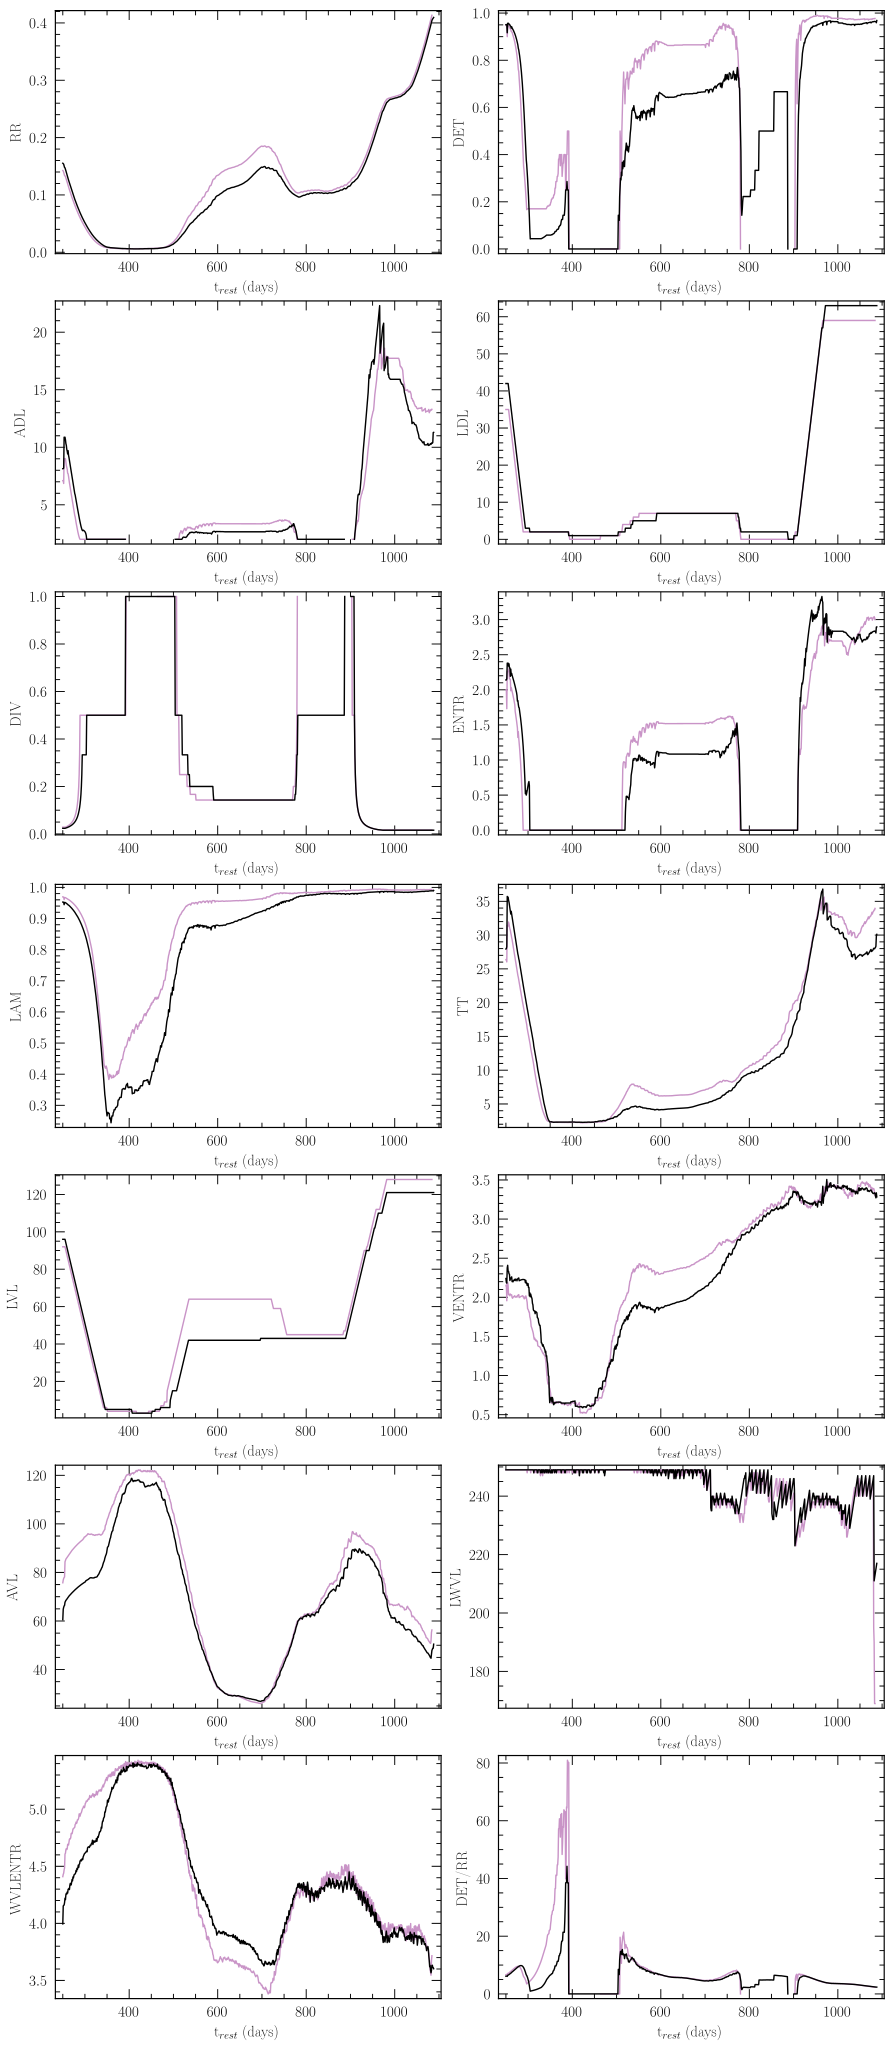

In [11]:
# WINDOWED RQA

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from pyrqa.time_series import EmbeddedSeries

# Function to calculate RQA measures for a given window
def calculate_rqa_measures(window, epsilon, tau, dim, i):

    # Construct embedded time series object
    embedded_ts = EmbeddedSeries(window)
    
    settings = Settings(embedded_ts,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(epsilon),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=tau*dim)
    
    # Perform RQA computation
    computation = RQAComputation.create(settings)
    result = computation.run()
    
    # Extract RQA measures
    rqa = get_rqa_measures(result)
    rqa['window'] = i  # Add window index to the results
    
    return rqa

# Function to compute measures in parallel for each window
def compute_measures_in_parallel(ts, tau, dim, window_size, step_size, epsilon):
    results = []
    
    # Define the sliding window
    for i in range(0, len(ts) - window_size + 1, step_size):
        window = ts[i:i + window_size]
        results.append(window)
    
    # Use Joblib to compute the measures in parallel
    parallel_results = Parallel(n_jobs=-1)(delayed(calculate_rqa_measures)(window, epsilon, tau, dim, i) for i, window in enumerate(results))
    
    # return pd.DataFrame(parallel_results)
    return parallel_results

import matplotlib.pyplot as plt

def plot_rqa_measures(df, fig, axes, color='k'):
    
    # Flatten the axes array for easy iterating
    axes = axes.flatten()

    # Plot each RQA measure in its own subplot
    for i, column in enumerate(df.columns[:-3]):  # Exclude the 'window' and 'time' columns if present
        ax = axes[i]
        ax.plot(df['time'], df[column], label=column, color=color)
        ax.set_xlabel(r't$_{rest}$ (days)')
        ax.set_ylabel(column)
        # else:
        #     ax_center.plot(df['time'], df[column], label=column, color=color)  # The second last column is the last metric

        # axes.append(ax)  # Store the axis

    return axes

# Example usage
window_size = 250
step_size = 1

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(13, 30))

rqa_stats = []
for i, (ts, tau, dim, color) in enumerate(zip([pred_lc, lc], [8, 9], [6, 5], ["#c994c7", 'k'])):
    
    # embed full time series
    embedded_ts = embed_time_series(ts, dim, tau)

    # check if find_epsilon differs 
    epsilon = find_epsilon(ts, 0.05, tau=tau, dim=dim) # use RR=5% across full RP
    rqa_df = compute_measures_in_parallel(embedded_ts, tau, dim, window_size, step_size, epsilon)
    
    # add column 'TIME' for center time of each window
    rqa_df['time'] = window_size + rqa_df['window'].values * step_size
    rqa_stats.append(rqa_df)
    
for rqa_df, color in zip(rqa_stats, ["#c994c7", 'k']):
    
    plot_rqa_measures(rqa_df, fig, axes, color=color)
        
plt.savefig('../plots/1ES_windowed_RQA_compare_DHO_fullRR_0.05.pdf', bbox_inches='tight')
plt.show()


In [118]:
for i, (ts, tau, dim) in enumerate(zip([lc, pred_lc], [9, 8], [5, 6])):
    
    # embed full time series
    embedded_ts = embed_time_series(ts, dim, tau)

    # check if find_epsilon differs 
    epsilon = find_epsilon(ts, 0.05, tau=tau, dim=dim) # use RR=5% across full RP
    print(f"Epsilon from original data: {epsilon}")
    epsilon = find_epsilon(embedded_ts, 0.05, tau=1, dim=1, theiler=tau*dim) # use RR=5% across full RP
    print(f"Epsilon from pre-embedded data: {epsilon}")

Found epsilon=0.0023040771484375 for RR=0.05006149978373702
Epsilon from original data: 0.36328125
Epsilon from pre-embedded data: 0.003437042352743447
Found epsilon=0.003437042352743447 for RR=0.05004187034490271
Epsilon from original data: 0.408203125
Found epsilon=0.408203125 for RR=0.049972086436731525
Epsilon from pre-embedded data: 0.0023040771484375
